Notebook to help with dashboard development

In [1]:
# set path to app.py
import sys
sys.path.append('../ev_sim/app/src')

from config import settings
import pandas as pd
from dateutil import parser

DATA_PATH = settings.DATA_PATH

Read in data for config

In [2]:
user_archetypes = pd.read_csv(DATA_PATH.joinpath("user-archetypes.csv"))
time_cols = ['ave_plug-in_time', 'ave_plug-out_time']
perc_cols = ['ave_target_SoC', 'ave_plug-in_SoC']

for col in time_cols:
    user_archetypes[col] = user_archetypes[col].apply(lambda x: parser.parse(x).time())

# from '10%' string to 0.1
for col in perc_cols:
    user_archetypes[col] = user_archetypes[col].apply(lambda x: float(x.strip('%'))/100)

user_archetypes

,name,proportion,ave_miles_per_yr,battery_ave_kWh,ave_efficiency_mi_per_kWh,ave_plug-in_frequency_per_day,charger_kW,ave_plug-in_time,ave_plug-out_time,ave_target_SoC,ave_plug-in_SoC
0,Average (UK),0.40,9435,60.0,3.5,1.0,7,18:00:00,07:00:00,0.8,0.68
1,Intelligent Octopus average,0.30,28105,72.5,3.5,1.0,7,18:00:00,07:00:00,0.8,0.52
2,Infrequent charging,0.10,9435,60.0,3.5,0.2,7,18:00:00,07:00:00,0.8,0.18
3,Infrequent driving,0.10,5700,60.0,3.5,1.0,7,18:00:00,07:00:00,0.8,0.73
4,Scheduled charging,0.09,9435,60.0,3.5,1.0,7,22:00:00,09:00:00,0.8,0.68
5,Always plugged-in,0.01,9435,60.0,3.5,1.0,7,00:00:00,23:59:00,0.8,0.68


In [3]:
user_archetypes

,name,proportion,ave_miles_per_yr,battery_ave_kWh,ave_efficiency_mi_per_kWh,ave_plug-in_frequency_per_day,charger_kW,ave_plug-in_time,ave_plug-out_time,ave_target_SoC,ave_plug-in_SoC
0,Average (UK),0.40,9435,60.0,3.5,1.0,7,18:00:00,07:00:00,0.8,0.68
1,Intelligent Octopus average,0.30,28105,72.5,3.5,1.0,7,18:00:00,07:00:00,0.8,0.52
2,Infrequent charging,0.10,9435,60.0,3.5,0.2,7,18:00:00,07:00:00,0.8,0.18
3,Infrequent driving,0.10,5700,60.0,3.5,1.0,7,18:00:00,07:00:00,0.8,0.73
4,Scheduled charging,0.09,9435,60.0,3.5,1.0,7,22:00:00,09:00:00,0.8,0.68
5,Always plugged-in,0.01,9435,60.0,3.5,1.0,7,00:00:00,23:59:00,0.8,0.68


In [4]:
# convert to datetime
examples_time_string = '6:00 pm'
frmt = 'H:mm a'
examples_time = parser.parse(examples_time_string).time()
examples_time


datetime.time(18, 0)

In [94]:
# check SoC logic w/ 2 user groups and 1 iteration
from simulation.parametric import run_monte_carlo
import numpy as np

no_of_iterations = 1
no_of_users = 1000
repeatable = True

USER_GROUPS = {
            "Average (UK)": {
                "pi-mean": 18,
                "pi-std": 2,
                "po-mean": 7,
                "po-std": 1,
                "soc-mean": 0.68,
                "soc-std": 0.3,
                "proportion": 0.4,
                "charging_rate": 7 / 60,
            },
            "Intel Octopus": {
                "pi-mean": 18,
                "pi-std": 2,
                "po-mean": 7,
                "po-std": 1,
                "soc-mean": 0.52,
                "soc-std": 0.3,
                "proportion": 0.3,
                "charging_rate": 7 / 60,
            },
}

domain = (0, 24)
plug_in_times = []
plug_in_times_group = {}
group_labels = []
for group in USER_GROUPS:
    ave_samples = []
    plug_in_times_group[group] = {}
    for _ in range(no_of_iterations):
        samples = run_monte_carlo(
            no_of_users=int(no_of_users * USER_GROUPS[group]["proportion"]),
            mean_of_dist=USER_GROUPS[group]["pi-mean"],
            std_of_dist=USER_GROUPS[group]["pi-std"],
            repeatable=repeatable,
            domain=domain,
        )
        plug_in_times.append(samples)
        group_labels.append(group)
        ave_samples.append(samples)
    plug_in_times_group[group]["mean"] = np.mean(ave_samples, axis=0)
    plug_in_times_group[group]["std"] = np.std(ave_samples, axis=0)

plug_out_times = []
plug_out_times_group = {}
group_labels = []
for group in USER_GROUPS:
    plug_out_times_group[group] = {}
    ave_samples = []
    for _ in range(no_of_iterations):
        samples = run_monte_carlo(
            no_of_users=int(no_of_users * USER_GROUPS[group]["proportion"]),
            mean_of_dist=USER_GROUPS[group]["po-mean"],
            std_of_dist=USER_GROUPS[group]["po-std"],
            repeatable=repeatable,
            domain=domain,
        )
        plug_out_times.append(samples)
        group_labels.append(group)
        ave_samples.append(samples)
    plug_out_times_group[group]["mean"] = np.mean(ave_samples, axis=0)
    plug_out_times_group[group]["std"] = np.std(ave_samples, axis=0)

domain = (0, 1)
plug_in_soc = []
plug_in_soc_group = {}
group_labels = []
for group in USER_GROUPS:
    plug_in_soc_group[group] = {}
    ave_samples = []
    for _ in range(no_of_iterations):
        samples = run_monte_carlo(
            no_of_users=int(no_of_users * USER_GROUPS[group]["proportion"]),
            mean_of_dist=USER_GROUPS[group]["soc-mean"],
            std_of_dist=USER_GROUPS[group]["soc-std"],
            repeatable=repeatable,
            domain=domain,
        )
        plug_in_soc.append(samples)
        group_labels.append(group)
        ave_samples.append(samples)
    plug_in_soc_group[group]["mean"] = np.mean(ave_samples, axis=0)
    plug_in_soc_group[group]["std"] = np.std(ave_samples, axis=0)


def count_plugged_in_bins(
    plug_in_times_group: dict,
    plug_out_times_group: dict,
    plug_in_soc_group: dict,
    no_of_users: int,
    user_groups: dict,
) -> tuple:
    # count in bins of 1 hour the plug in times
    x_range = range(0, 25, 1)
    plug_in_times, plug_in_times_upper, plug_in_times_lower = [], [], []
    for group in user_groups.keys():
        plug_in_times.extend(plug_in_times_group[group]["mean"])
        plug_in_times_upper.extend(
            plug_in_times_group[group]["mean"] + plug_in_times_group[group]["std"]
        )
        plug_in_times_lower.extend(
            plug_in_times_group[group]["mean"] - plug_in_times_group[group]["std"]
        )
    s_plug_in_count = (
        pd.Series(plug_in_times).value_counts(bins=x_range).sort_index().cumsum()
    )
    s_plug_in_count_upper = (
        pd.Series(plug_in_times_upper).value_counts(bins=x_range).sort_index().cumsum()
    )
    s_plug_in_count_lower = (
        pd.Series(plug_in_times_lower).value_counts(bins=x_range).sort_index().cumsum()
    )

    # count in bins of 1 hour the plug out times
    plug_out_times, plug_out_times_upper, plug_out_times_lower = [], [], []
    for group in user_groups.keys():
        plug_out_times.extend(plug_out_times_group[group]["mean"])
        plug_out_times_upper.extend(
            plug_out_times_group[group]["mean"] + plug_out_times_group[group]["std"]
        )
        plug_out_times_lower.extend(
            plug_out_times_group[group]["mean"] - plug_out_times_group[group]["std"]
        )

    s_plug_out_count = (
        pd.Series(plug_out_times).value_counts(bins=x_range).sort_index().cumsum()
    )
    s_plug_out_count_upper = (
        pd.Series(plug_out_times_upper).value_counts(bins=x_range).sort_index().cumsum()
    )
    s_plug_out_count_lower = (
        pd.Series(plug_out_times_lower).value_counts(bins=x_range).sort_index().cumsum()
    )

    # in each bin, take the number plugged in minus the number plugged out
    s_plug_in_out_count = (
        no_of_users - (s_plug_out_count - s_plug_in_count)
    ) / no_of_users
    s_plug_in_out_count_upper = (
        no_of_users - (s_plug_out_count_upper - s_plug_in_count_lower)
    ) / no_of_users
    s_plug_in_out_count_lower = (
        no_of_users - (s_plug_out_count_lower - s_plug_in_count_upper)
    ) / no_of_users

    return (
        s_plug_in_out_count,
        s_plug_in_out_count_upper,
        s_plug_in_out_count_lower,
    )



(
    s_plug_in_out_count,
    s_plug_in_out_count_upper,
    s_plug_in_out_count_lower,
) = count_plugged_in_bins(
    plug_in_times_group,
    plug_out_times_group,
    plug_in_soc_group,
    no_of_users,
    USER_GROUPS,
)

In [113]:
# generate interval index from 0-1 till 24-25
time_intervals = pd.interval_range(start=0, end=24, freq=1, closed="right")

In [121]:
x_range = range(0, 25, 1)

soc_bins = pd.DataFrame()

for group in USER_GROUPS.keys():
    group_plug_in = pd.Series(plug_in_times_group[group]["mean"]).value_counts(bins=x_range).sort_index().cumsum()
    group_plug_out = pd.Series(plug_out_times_group[group]["mean"]).value_counts(bins=x_range).sort_index().cumsum()
    group_plug_in_out =  no_of_users * USER_GROUPS[group]['proportion'] - (group_plug_out - group_plug_in)
    time_intervals = group_plug_in.index

    soc = plug_in_soc_group[group]["mean"].copy()
    soc_upper = plug_in_soc_group[group]["mean"].copy() + plug_in_soc_group[group]["std"].copy()
    soc_lower = plug_in_soc_group[group]["mean"].copy() - plug_in_soc_group[group]["std"].copy()
    charging_rate = USER_GROUPS[group]["charging_rate"]
    no_online = 0
    # reorder time_intervals to start from midday
    time_intervals_reordered = time_intervals[12:].append(time_intervals[:12])
    for time_interval in time_intervals_reordered:
        no_online = int(group_plug_in_out[time_interval])
        # increase soc[:no_online] by charging_rate
        soc[:no_online] = soc[:no_online] + charging_rate
        soc[soc > 1] = 1
        soc_upper[:no_online] = soc_upper[:no_online] + charging_rate
        soc_upper[soc_upper > 1] = 1
        soc_lower[:no_online] = soc_lower[:no_online] + charging_rate
        soc_lower[soc_lower > 1] = 1
        soc_bins.loc[time_interval, f'{group}_mean'] = np.mean(soc)
        soc_bins.loc[time_interval, f'{group}_upper'] = np.mean(soc_upper) + np.std(soc_upper)
        soc_bins.loc[time_interval, f'{group}_lower'] = np.mean(soc_lower) - np.std(soc_lower) 


In [126]:
# sort index to start from 0
soc_bins = soc_bins.sort_index()
soc_bins

,Average (UK)_mean,Average (UK)_upper,Average (UK)_lower,Intel Octopus_mean,Intel Octopus_upper,Intel Octopus_lower
"(-0.001, 1.0]",0.988378,1.034726,0.942030,0.980438,1.052778,0.908099
"(1.0, 2.0]",0.996197,1.020015,0.972379,0.990566,1.038185,0.942947
"(2.0, 3.0]",0.999080,1.009563,0.988597,0.995659,1.023722,0.967595
"(3.0, 4.0]",0.999846,1.002923,0.996769,0.998530,1.011128,0.985932
"(4.0, 5.0]",1.000000,1.000000,1.000000,0.999552,1.007306,0.991797
"(5.0, 6.0]",1.000000,1.000000,1.000000,0.999552,1.007306,0.991797
"(6.0, 7.0]",1.000000,1.000000,1.000000,0.999552,1.007306,0.991797
"(7.0, 8.0]",1.000000,1.000000,1.000000,0.999552,1.007306,0.991797
"(8.0, 9.0]",1.000000,1.000000,1.000000,0.999552,1.007306,0.991797
"(9.0, 10.0]",1.000000,1.000000,1.000000,0.999552,1.007306,0.991797


In [35]:
arr[random_indexes]

array([0.71136737, 0.46850731])

In [128]:
for group, _ in USER_GROUPS.items():
    print(group)

Average (UK)
Intel Octopus


In [130]:
soc_bins.mean(axis=1)

(-0.001, 1.0]    0.984408
(1.0, 2.0]       0.993381
(2.0, 3.0]       0.997369
(3.0, 4.0]       0.999188
(4.0, 5.0]       0.999776
(5.0, 6.0]       0.999776
(6.0, 7.0]       0.999776
(7.0, 8.0]       0.999776
(8.0, 9.0]       0.999776
(9.0, 10.0]      0.999776
(10.0, 11.0]     0.999776
(11.0, 12.0]     0.999776
(12.0, 13.0]     0.556515
(13.0, 14.0]     0.558848
(14.0, 15.0]     0.566956
(15.0, 16.0]     0.584799
(16.0, 17.0]     0.617422
(17.0, 18.0]     0.662976
(18.0, 19.0]     0.723505
(19.0, 20.0]     0.788984
(20.0, 21.0]     0.851519
(21.0, 22.0]     0.905181
(22.0, 23.0]     0.943693
(23.0, 24.0]     0.968573
dtype: float64

A single user:
- have own values for their distributions


1. Draw sample from architypes, single number -> single user's mean
2. Gen distribution based on that selected mean (assumed std)
3. sample from the user-dist for period




In [10]:
# random list


array([0.46530984, 0.63400076, 0.14791357, 0.17879924, 0.38968287,
       0.54106169, 0.73779867, 0.22561169, 0.34376304, 0.03208705,
       0.36501651, 0.95614741, 0.347284  , 0.6957634 , 0.76428842,
       0.82091377, 0.28450157, 0.82042258, 0.36604107, 0.69812223,
       0.1166157 , 0.33505915, 0.55257525, 0.22842905, 0.29784783,
       0.78440026, 0.60425839, 0.84859916, 0.90753172, 0.02384678,
       0.62669458, 0.17374321, 0.81542101, 0.05660613, 0.86884505,
       0.50017786, 0.8358227 , 0.02425804, 0.47278634, 0.06161466,
       0.45886179, 0.19735594, 0.05708914, 0.88248001, 0.01905127,
       0.87926566, 0.54888805, 0.17969021, 0.3466134 , 0.81385536,
       0.11078467, 0.95618857, 0.58714236, 0.48324009, 0.11878847,
       0.16445846, 0.45837359, 0.60262172, 0.78741231, 0.55872489,
       0.72065275, 0.94306242, 0.56917679, 0.21701145, 0.9249842 ,
       0.65857312, 0.11448867, 0.16304832, 0.79003493, 0.66319171,
       0.29597491, 0.22254378, 0.89204619, 0.66581   , 0.78105

In [37]:
from scipy.stats import norm
from scipy.stats.sampling import NumericalInversePolynomial
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
import seaborn as sns

def user_dist(mean_a: float, std_a: float, domain = (0, 1), assumed_std_user = 0.1):

    architypes_dist = norm(mean_a, std_a)
    random_state = RandomState()
    inverse_cdf = NumericalInversePolynomial(architypes_dist, domain=domain)

    # pick single user
    user_mean = inverse_cdf.rvs(size=1)[0]
    user_dist = norm(user_mean, assumed_std_user)

    # run year
    no_days = 365
    inverse_cdf = NumericalInversePolynomial(user_dist, domain=domain)
    inverse_cdf_samples = inverse_cdf.rvs(size=no_days,  random_state=random_state)

    return inverse_cdf_samples


In [49]:
no_users = 50
architype = {
    1:{
        'mean_a': 0.52,
        'std_a': 0.3
    },
}

user_samples = []
for _ in range(no_users):
    # soc
    user_sample = user_dist(architype[1]['mean_a'], architype[1]['std_a'])
    user_samples.append(user_sample)

# plot each user in user_samples
architypes_dist = norm(0.52, 0.3)
random_state = RandomState()
inverse_cdf = NumericalInversePolynomial(architypes_dist, domain=domain)

# 

sns.histplot(user_samples, bins=100, kde=True, alpha=0.5)


<Axes: ylabel='Count'>

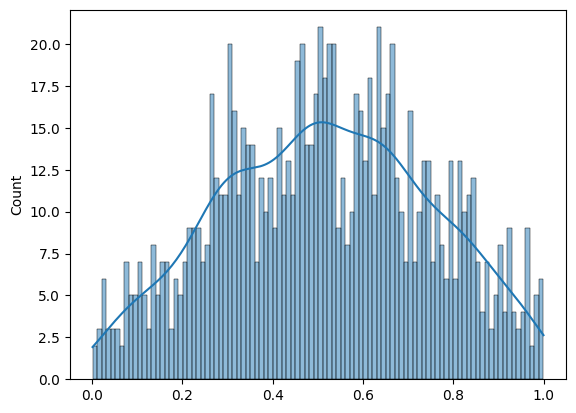

In [44]:
sns.histplot(inverse_cdf.rvs(size=1000,  random_state=random_state), bins=100, kde=True)

In [40]:
user_samples[0]

array([0.3084477 , 0.31328583, 0.41970664, 0.39266841, 0.4899894 ,
       0.26187036, 0.26518179, 0.31920057, 0.32790051, 0.29742829,
       0.34245332, 0.20588631, 0.15330245, 0.16110405, 0.2838628 ,
       0.36711563, 0.39669894, 0.19744087, 0.33166076, 0.22322585,
       0.35745019, 0.25245715, 0.07342227, 0.33338534, 0.16064599,
       0.30299023, 0.32521082, 0.28738595, 0.37243687, 0.36064111,
       0.35578805, 0.43038626, 0.34031981, 0.27351977, 0.23567845,
       0.34860047, 0.42287135, 0.41363951, 0.45880268, 0.39792072,
       0.33688284, 0.33231168, 0.18042175, 0.33079239, 0.34607455,
       0.3455481 , 0.31965271, 0.33465087, 0.32014011, 0.39700243,
       0.32490833, 0.36571962, 0.35310451, 0.41480801, 0.39272174,
       0.13742565, 0.38192916, 0.16593193, 0.34118136, 0.46369064,
       0.12949737, 0.30084682, 0.40472612, 0.46051648, 0.38703375,
       0.27253748, 0.34658217, 0.40050435, 0.25037068, 0.28691702,
       0.30345135, 0.34043938, 0.46600969, 0.36300828, 0.34552

In [32]:
architypes_dist.ppf(0.991)

1.2296854380592879